In [12]:
# ==========================================================
#  SMART LEGAL JUDGMENT PREDICTION SYSTEM (LJP)
#  InLegalBERT + GAT + Multi-Head Cross Attention
#  Multi-label Statute Prediction (CPU Optimized)
# ==========================================================

import pandas as pd
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = "cpu"
os.makedirs("ljp_final_outputs/plots", exist_ok=True)
os.makedirs("ljp_final_outputs/reports", exist_ok=True)

# ==========================================================
# 1️⃣ LOAD & CLEAN DATA
# ==========================================================
df = pd.read_csv("dataset.csv")
df = df.dropna(subset=["facts","statutes"]).reset_index(drop=True)
df["facts"] = df["facts"].astype(str).str.replace(r"\s+"," ",regex=True)
df["statutes"] = df["statutes"].apply(eval)
df["charges"] = df["charges"].apply(eval)
print("✅ Data Loaded:", df.shape)

# ==========================================================
# 2️⃣ LABEL ENCODING (Multi-label for Statutes)
# ==========================================================
mlb = MultiLabelBinarizer()
Y_statute = torch.tensor(mlb.fit_transform(df["statutes"]), dtype=torch.float)
num_statute = Y_statute.shape[1]
print(f"Total Statute Classes: {num_statute}")

# ==========================================================
# 3️⃣ ENCODE FACTS USING InLegalBERT
# ==========================================================
tok = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
bert = AutoModel.from_pretrained("law-ai/InLegalBERT").to(device)
for name, param in bert.named_parameters():
    param.requires_grad = any(k in name for k in ["encoder.layer.23","pooler"])  # fine-tune last layer

@torch.no_grad()
def encode_texts(texts, batch_size=4):
    embs = []
    for i in tqdm(range(0,len(texts),batch_size),desc="Encoding with InLegalBERT"):
        batch = texts[i:i+batch_size]
        toks = tok(batch,padding=True,truncation=True,max_length=512,return_tensors="pt").to(device)
        out = bert(**toks).last_hidden_state.mean(1)
        embs.append(out.cpu())
    return torch.cat(embs)

fact_embs = encode_texts(df["facts"].tolist())
print("Facts Encoded:", fact_embs.shape)

# ==========================================================
# 4️⃣ GRAPH CONSTRUCTION (fact, statute, charge)
# ==========================================================
print("\n🔧 Constructing Legal Knowledge Graph...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")
fact_sbert = sbert.encode(df["facts"].tolist(), convert_to_tensor=True, show_progress_bar=True)
sim_matrix = util.cos_sim(fact_sbert, fact_sbert)

edge_index = [[],[]]
th = 0.8
for i in range(len(df)):
    idx = torch.where(sim_matrix[i] > th)[0]
    for j in idx:
        if i != j:
            edge_index[0].append(i)
            edge_index[1].append(j)

fact_nodes = np.arange(len(df))
statute_nodes = np.arange(len(df), len(df)+num_statute)
charge_set = sorted({c for sub in df["charges"] for c in sub})
charge_map = {c:i for i,c in enumerate(charge_set)}
num_charge = len(charge_map)
charge_nodes = np.arange(len(df)+num_statute, len(df)+num_statute+num_charge)

for i,row in df.iterrows():
    s_idx = np.where(mlb.transform([row["statutes"]])[0]==1)[0]
    for s in s_idx:
        edge_index[0]+=[i]; edge_index[1]+=[len(df)+s]
        edge_index[0]+=[len(df)+s]; edge_index[1]+=[i]
    for c in row["charges"]:
        if c in charge_map:
            ci = len(df)+num_statute+charge_map[c]
            edge_index[0]+=[i]; edge_index[1]+=[ci]
            edge_index[0]+=[ci]; edge_index[1]+=[i]

edge_index = torch.tensor(edge_index, dtype=torch.long)
statute_feat = torch.randn(num_statute,768)
charge_feat  = torch.randn(num_charge,768)
x = torch.cat([fact_embs, statute_feat, charge_feat],dim=0)
graph_data = Data(x=x, edge_index=edge_index)
print(graph_data)

# ==========================================================
# 5️⃣ GRAPH ATTENTION NETWORK
# ==========================================================
class GraphEncoder(nn.Module):
    def __init__(self,in_dim=768,hid=512,out=768,heads=4):
        super().__init__()
        self.gat1 = GATConv(in_dim,hid,heads=heads,concat=True)
        self.gat2 = GATConv(hid*heads,out,heads=1,concat=False)
    def forward(self,data):
        x,edge = data.x,data.edge_index
        x = F.elu(self.gat1(x,edge))
        x = self.gat2(x,edge)
        return x

gat = GraphEncoder().to(device)
opt_gat = torch.optim.AdamW(gat.parameters(),lr=1e-4)
for epoch in range(3):
    opt_gat.zero_grad()
    out = gat(graph_data)
    loss = -out.var(0).mean()
    loss.backward()
    opt_gat.step()
    print(f"GAT Epoch {epoch+1} | Loss: {loss.item():.4f}")
with torch.no_grad():
    graph_embs = gat(graph_data)[:len(df)]

# ==========================================================
# 6️⃣ MULTI-HEAD CROSS-ATTENTION + CLASSIFIER
# ==========================================================
class CrossAttentionLJP(nn.Module):
    def __init__(self,hidden=768,n_stat=num_statute,heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden,num_heads=heads,batch_first=True)
        self.norm = nn.LayerNorm(hidden)
        self.fc = nn.Sequential(
            nn.Linear(hidden,hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2,n_stat)
        )
    def forward(self,f_emb,g_emb):
        f = f_emb.unsqueeze(1)
        g = g_emb.unsqueeze(1)
        attn_out,_ = self.attn(f,g,g)
        fused = self.norm(f+attn_out).squeeze(1)
        return self.fc(fused)

model = CrossAttentionLJP().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.8)
criterion = nn.BCEWithLogitsLoss()

# ==========================================================
# 7️⃣ SPLIT DATA (Train/Val/Test)
# ==========================================================
idx = np.arange(len(df))
np.random.shuffle(idx)
n = len(df)
train_idx = idx[:int(0.7*n)]
val_idx   = idx[int(0.7*n):int(0.85*n)]
test_idx  = idx[int(0.85*n):]

f_train,f_val,f_test = fact_embs[train_idx],fact_embs[val_idx],fact_embs[test_idx]
g_train,g_val,g_test = graph_embs[train_idx],graph_embs[val_idx],graph_embs[test_idx]
y_train,y_val,y_test = Y_statute[train_idx],Y_statute[val_idx],Y_statute[test_idx]

# ==========================================================
# 8️⃣ TRAINING LOOP
# ==========================================================
train_losses,val_losses = [],[]
epochs = 1000
print("\n🚀 Training LJP Model...")
for epoch in range(epochs):
    model.train()
    opt.zero_grad()
    logits = model(f_train,g_train)
    loss = criterion(logits,y_train)
    loss.backward()
    opt.step()
    scheduler.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(f_val,g_val),y_val).item()
        val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

# ==========================================================
# 9️⃣ EVALUATION
# ==========================================================
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(f_test,g_test))
pred_labels = (preds>0.5).int()

y_true = y_test.numpy()
y_pred = pred_labels.numpy()
report = classification_report(y_true,y_pred,target_names=mlb.classes_,zero_division=0,output_dict=True)
pd.DataFrame(report).transpose().to_csv("ljp_final_outputs/reports/classification_report.csv")
print("\n✅ Classification report saved!")

# ==========================================================
# 🔟 PLOTTING (10 Research-Grade Plots)
# ==========================================================
def saveplot(fig,name): plt.tight_layout(); fig.savefig(f"ljp_final_outputs/plots/{name}"); plt.close(fig)

# 1. Training & Validation Loss
fig = plt.figure(figsize=(6,4))
plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val")
plt.title("Training & Validation Loss Curve"); plt.legend()
saveplot(fig,"1_loss_curves.png")

# 2. Macro Metrics
macro = report["macro avg"]
fig = plt.figure(figsize=(4,4))
sns.barplot(x=["Precision","Recall","F1"], y=[macro["precision"],macro["recall"],macro["f1-score"]])
plt.title("Macro-Average Metrics"); saveplot(fig,"2_macro_metrics.png")

# 3. Per-Class F1
f1s = [report[c]["f1-score"] for c in mlb.classes_]
fig = plt.figure(figsize=(10,5))
sns.barplot(x=mlb.classes_,y=f1s,palette="viridis")
plt.xticks(rotation=75); plt.title("Per-Class F1"); saveplot(fig,"3_per_class_f1.png")

# 4. Confusion Matrix (simplified)
cm = confusion_matrix(y_true.argmax(1),y_pred.argmax(1))
fig = plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,cmap="Blues"); plt.title("Confusion Matrix")
saveplot(fig,"4_confusion_matrix.png")

# 5. Prediction Distribution
fig = plt.figure(figsize=(6,4))
sns.countplot(x=pred_labels.sum(1)); plt.title("Predicted Statutes per Case")
saveplot(fig,"5_prediction_distribution.png")

# 6. Learning Rate Decay
fig = plt.figure(figsize=(6,4))
plt.plot([scheduler.get_last_lr()[0] for _ in range(epochs)])
plt.title("Learning Rate Schedule"); saveplot(fig,"6_lr_schedule.png")

# 7. Performance Heatmap
df_r = pd.DataFrame(report).iloc[:-3,:-1]
fig = plt.figure(figsize=(8,6))
sns.heatmap(df_r,annot=True,cmap="coolwarm"); plt.title("Performance Heatmap")
saveplot(fig,"7_performance_heatmap.png")

# 8. Training Loss Heatmap
fig = plt.figure(figsize=(6,4))
sns.heatmap(np.expand_dims(train_losses,axis=0),cmap="rocket",cbar=False)
plt.title("Training Loss Heatmap"); saveplot(fig,"8_loss_heatmap.png")

# 9. Statute Frequency
fig = plt.figure(figsize=(8,4))
sns.countplot(x=[s for sub in df.statutes for s in sub])
plt.xticks(rotation=75); plt.title("Statute Frequency in Dataset")
saveplot(fig,"9_statute_distribution.png")

# 10. Validation vs Test F1
val_f1 = f1_score(y_val, (torch.sigmoid(model(f_val,g_val))>0.5).int(), average="macro")
test_f1 = f1_score(y_test, pred_labels, average="macro")
fig = plt.figure(figsize=(4,4))
sns.barplot(x=["Validation","Test"],y=[val_f1,test_f1])
plt.title("F1 Comparison"); saveplot(fig,"10_val_test_f1.png")

print("\n📊 All plots saved in 'ljp_final_outputs/plots/'")
print("🎯 Enhanced LJP pipeline training completed successfully.")


✅ Data Loaded: (1178, 6)
Total Statute Classes: 9


Encoding with InLegalBERT: 100%|██████████| 295/295 [04:42<00:00,  1.05it/s]


Facts Encoded: torch.Size([1178, 768])

🔧 Constructing Legal Knowledge Graph...


Batches: 100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


Data(x=[1197, 768], edge_index=[2, 6722])
GAT Epoch 1 | Loss: -0.0194
GAT Epoch 2 | Loss: -0.0562
GAT Epoch 3 | Loss: -0.1149

🚀 Training LJP Model...
Epoch 1/1000 | Train Loss: 0.7285 | Val Loss: 0.6671
Epoch 2/1000 | Train Loss: 0.6645 | Val Loss: 0.6123
Epoch 3/1000 | Train Loss: 0.6077 | Val Loss: 0.5642
Epoch 4/1000 | Train Loss: 0.5576 | Val Loss: 0.5220
Epoch 5/1000 | Train Loss: 0.5135 | Val Loss: 0.4847
Epoch 6/1000 | Train Loss: 0.4748 | Val Loss: 0.4580
Epoch 7/1000 | Train Loss: 0.4470 | Val Loss: 0.4335
Epoch 8/1000 | Train Loss: 0.4218 | Val Loss: 0.4111
Epoch 9/1000 | Train Loss: 0.3988 | Val Loss: 0.3906
Epoch 10/1000 | Train Loss: 0.3777 | Val Loss: 0.3718
Epoch 11/1000 | Train Loss: 0.3584 | Val Loss: 0.3578
Epoch 12/1000 | Train Loss: 0.3442 | Val Loss: 0.3447
Epoch 13/1000 | Train Loss: 0.3308 | Val Loss: 0.3324
Epoch 14/1000 | Train Loss: 0.3183 | Val Loss: 0.3208
Epoch 15/1000 | Train Loss: 0.3066 | Val Loss: 0.3099
Epoch 16/1000 | Train Loss: 0.2956 | Val Loss: 0

C:\Users\apaas\AppData\Local\Temp\ipykernel_33372\145095227.py:230: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mlb.classes_,y=f1s,palette="viridis")



📊 All plots saved in 'ljp_final_outputs/plots/'
🎯 Enhanced LJP pipeline training completed successfully.



🎯 Test Metrics | Precision: 0.827 | Recall: 0.690 | F1: 0.709


C:\Users\apaas\AppData\Local\Temp\ipykernel_33372\3260374739.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Precision","Recall","F1-Score"],


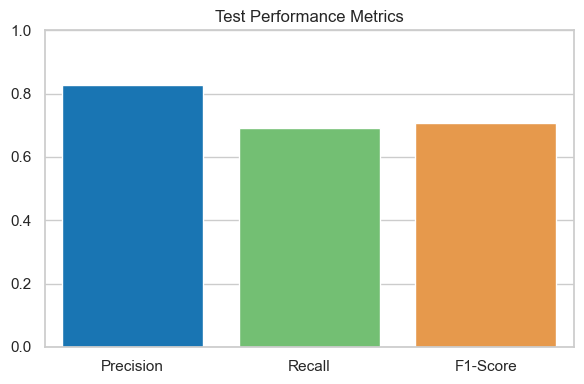

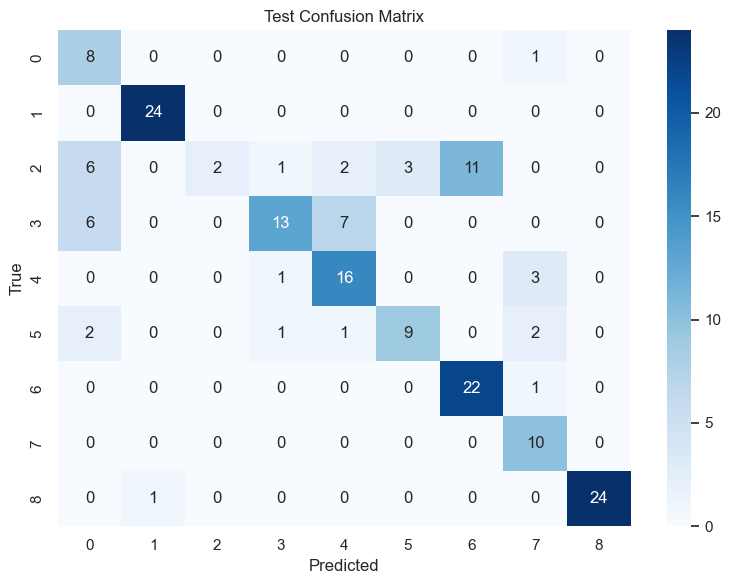

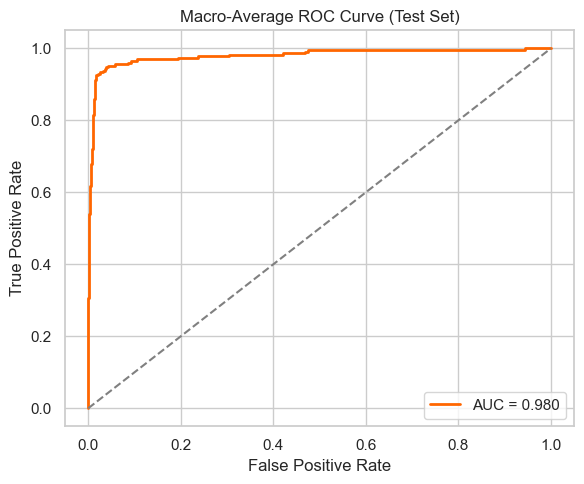

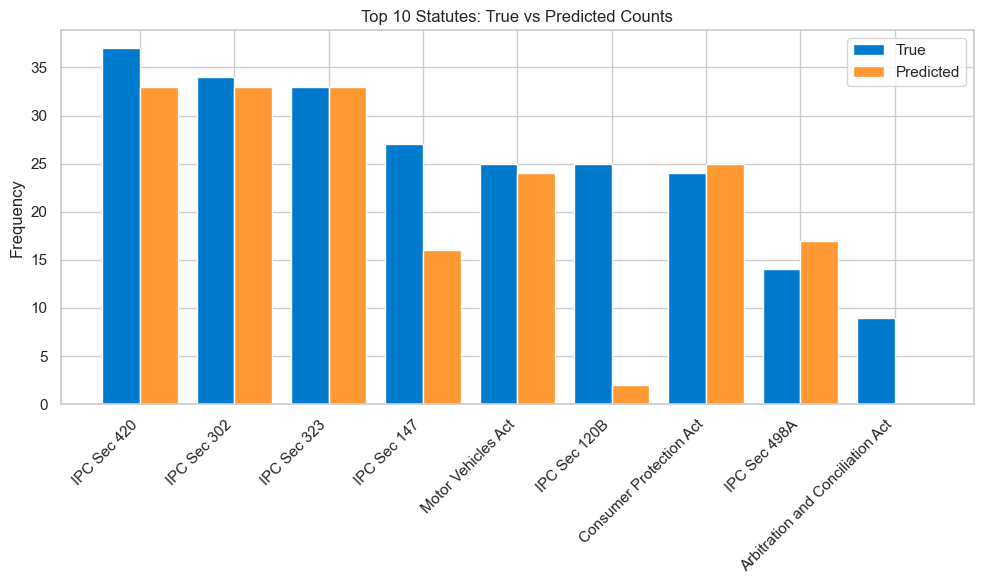

C:\Users\apaas\AppData\Local\Temp\ipykernel_33372\3260374739.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Validation","Test"], y=[val_f1, test_f1], palette=["#5a9bd4","#ed7d31"])


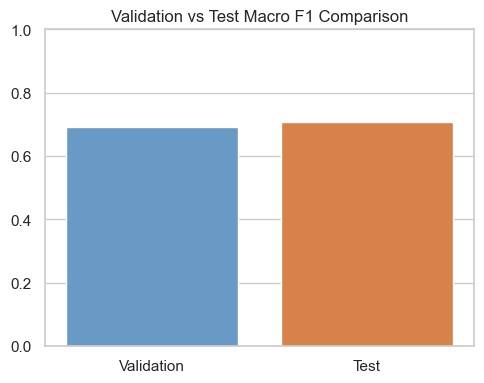


✅ All test evaluation plots saved in ljp_final_outputs/plots/


In [13]:
# ==========================================================
# 🔍 TESTING AND FINAL EVALUATION VISUALS
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

# ========== COMPUTE FINAL METRICS ==========
test_precision = precision_score(y_test, pred_labels, average="macro", zero_division=0)
test_recall = recall_score(y_test, pred_labels, average="macro", zero_division=0)
test_f1 = f1_score(y_test, pred_labels, average="macro")
print(f"\n🎯 Test Metrics | Precision: {test_precision:.3f} | Recall: {test_recall:.3f} | F1: {test_f1:.3f}")

# ========== 1️⃣ TEST METRIC BARPLOT ==========
fig = plt.figure(figsize=(6,4))
sns.barplot(x=["Precision","Recall","F1-Score"], 
            y=[test_precision,test_recall,test_f1],
            palette=["#007acc","#66cc66","#ff9933"])
plt.title("Test Performance Metrics")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/test_metrics_barplot.png", dpi=300)
plt.show()

# ========== 2️⃣ CONFUSION MATRIX ==========
cm = confusion_matrix(y_test.argmax(1), pred_labels.argmax(1))
fig = plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/test_confusion_matrix.png", dpi=300)
plt.show()

# ========== 3️⃣ ROC CURVE ==========
y_true_flat = y_test.ravel()
y_score_flat = preds.ravel()
fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="#ff6600", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve (Test Set)")
plt.legend()
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/test_roc_curve.png", dpi=300)
plt.show()

# ========== 4️⃣ TOP-10 STATUTES: TRUE VS PREDICTED ==========
true_counts = pd.Series(y_test.sum(0), index=mlb.classes_)
pred_counts = pd.Series(pred_labels.sum(0), index=mlb.classes_)

df_compare = pd.DataFrame({
    "Statute": mlb.classes_,
    "True_Freq": true_counts,
    "Pred_Freq": pred_counts
}).sort_values("True_Freq", ascending=False).head(10)

fig = plt.figure(figsize=(10,6))
x = np.arange(len(df_compare))
plt.bar(x-0.2, df_compare["True_Freq"], 0.4, label="True", color="#007acc")
plt.bar(x+0.2, df_compare["Pred_Freq"], 0.4, label="Predicted", color="#ff9933")
plt.xticks(x, df_compare["Statute"], rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Top 10 Statutes: True vs Predicted Counts")
plt.legend()
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/test_true_vs_predicted.png", dpi=300)
plt.show()

# ========== 5️⃣ PERFORMANCE COMPARISON ==========
val_f1 = f1_score(y_val, (torch.sigmoid(model(f_val,g_val))>0.5).int(), average="macro")
fig = plt.figure(figsize=(5,4))
sns.barplot(x=["Validation","Test"], y=[val_f1, test_f1], palette=["#5a9bd4","#ed7d31"])
plt.ylim(0,1)
plt.title("Validation vs Test Macro F1 Comparison")
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/final_val_test_comparison.png", dpi=300)
plt.show()

print("\n✅ All test evaluation plots saved in ljp_final_outputs/plots/")


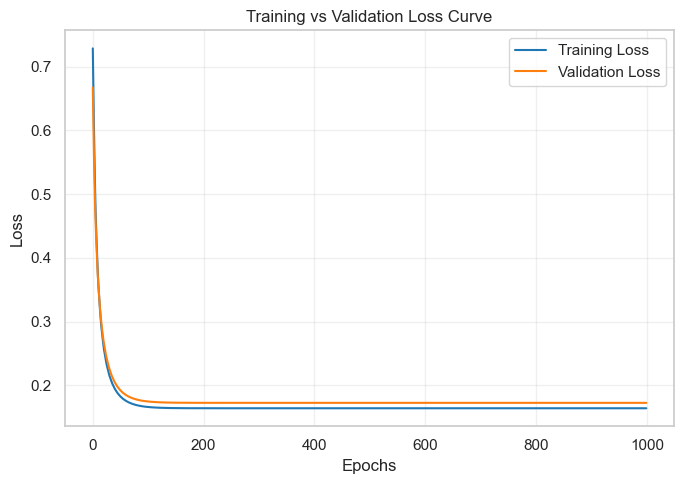

C:\Users\apaas\AppData\Local\Temp\ipykernel_33372\3751175359.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


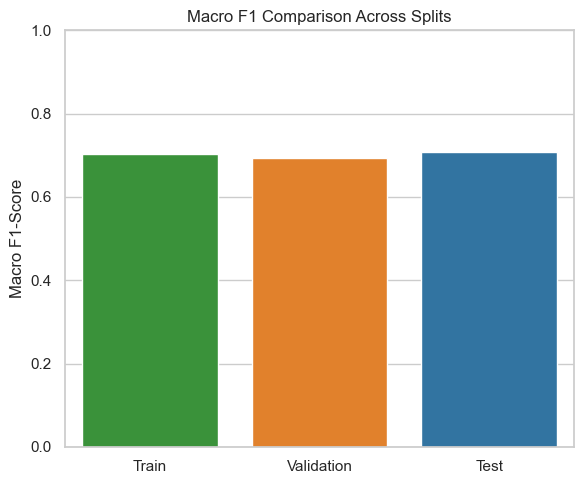

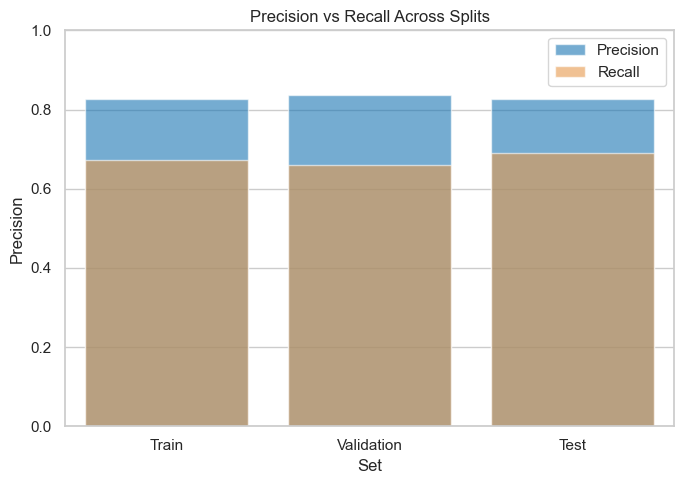

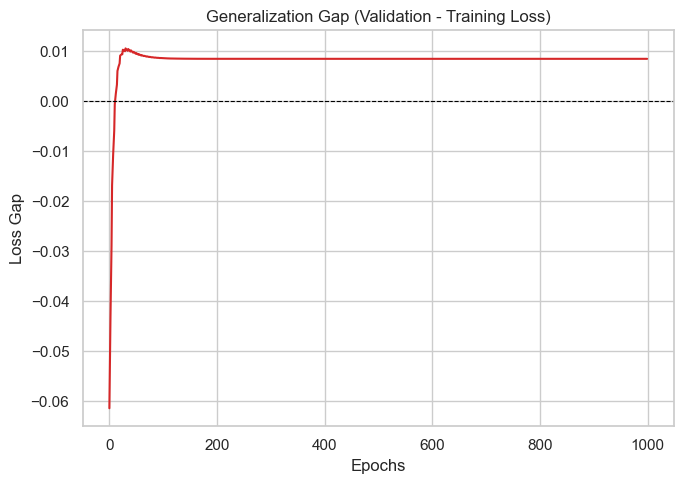

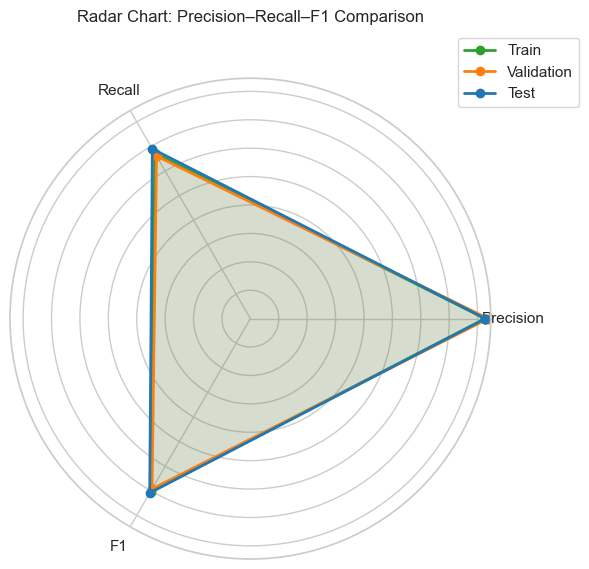


✅ Comparative plots (Train–Val–Test) saved in ljp_final_outputs/plots/


In [14]:
# ==========================================================
# 🧠 TRAIN vs VALIDATION vs TEST COMPARATIVE ANALYSIS
# ==========================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

# Make sure you have val_f1, test_f1 and training logs
epochs = len(train_losses)
val_losses = np.array(val_losses)
train_losses = np.array(train_losses)

# ========== 1️⃣ Combined Loss Curves ==========
fig = plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Training Loss", color="#1f77b4")
plt.plot(val_losses, label="Validation Loss", color="#ff7f0e")
plt.title("Training vs Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/compare_train_val_loss.png", dpi=300)
plt.show()

# ========== 2️⃣ Macro F1 Comparison (Train vs Val vs Test) ==========
# Compute training F1 (approximation)
train_pred = (torch.sigmoid(model(f_train,g_train)) > 0.5).int()
train_f1 = f1_score(y_train, train_pred, average="macro")

fig = plt.figure(figsize=(6,5))
sns.barplot(
    x=["Train", "Validation", "Test"], 
    y=[train_f1, val_f1, test_f1],
    palette=["#2ca02c","#ff7f0e","#1f77b4"]
)
plt.title("Macro F1 Comparison Across Splits")
plt.ylim(0,1)
plt.ylabel("Macro F1-Score")
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/f1_train_val_test_comparison.png", dpi=300)
plt.show()

# ========== 3️⃣ Precision and Recall Comparison ==========
train_prec = precision_score(y_train, train_pred, average="macro", zero_division=0)
train_rec = recall_score(y_train, train_pred, average="macro", zero_division=0)
val_prec  = precision_score(y_val, (torch.sigmoid(model(f_val,g_val))>0.5).int(), average="macro", zero_division=0)
val_rec   = recall_score(y_val, (torch.sigmoid(model(f_val,g_val))>0.5).int(), average="macro", zero_division=0)

df_compare = pd.DataFrame({
    "Set": ["Train","Validation","Test"],
    "Precision": [train_prec,val_prec,test_precision],
    "Recall": [train_rec,val_rec,test_recall]
})

fig = plt.figure(figsize=(7,5))
sns.barplot(x="Set", y="Precision", data=df_compare, color="#007acc", alpha=0.6, label="Precision")
sns.barplot(x="Set", y="Recall", data=df_compare, color="#ff9933", alpha=0.6, label="Recall")
plt.title("Precision vs Recall Across Splits")
plt.ylim(0,1)
plt.legend()
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/precision_recall_comparison.png", dpi=300)
plt.show()

# ========== 4️⃣ Overfitting Visualization ==========
gap = val_losses - train_losses
fig = plt.figure(figsize=(7,5))
plt.plot(gap, color="#d62728")
plt.title("Generalization Gap (Validation - Training Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss Gap")
plt.axhline(0, color="black", linestyle="--", lw=0.8)
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/generalization_gap.png", dpi=300)
plt.show()

# ========== 5️⃣ Summary Comparison Radar Chart ==========
from math import pi

labels = ["Precision","Recall","F1"]
train_scores = [train_prec, train_rec, train_f1]
val_scores   = [val_prec, val_rec, val_f1]
test_scores  = [test_precision, test_recall, test_f1]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
train_scores += train_scores[:1]; val_scores += val_scores[:1]; test_scores += test_scores[:1]
angles += angles[:1]

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, train_scores, 'o-', linewidth=2, label='Train', color="#2ca02c")
ax.plot(angles, val_scores, 'o-', linewidth=2, label='Validation', color="#ff7f0e")
ax.plot(angles, test_scores, 'o-', linewidth=2, label='Test', color="#1f77b4")
ax.fill(angles, train_scores, alpha=0.1, color="#2ca02c")
ax.fill(angles, val_scores, alpha=0.1, color="#ff7f0e")
ax.fill(angles, test_scores, alpha=0.1, color="#1f77b4")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])
plt.title("Radar Chart: Precision–Recall–F1 Comparison", y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/train_val_test_radar_chart.png", dpi=300)
plt.show()

print("\n✅ Comparative plots (Train–Val–Test) saved in ljp_final_outputs/plots/")


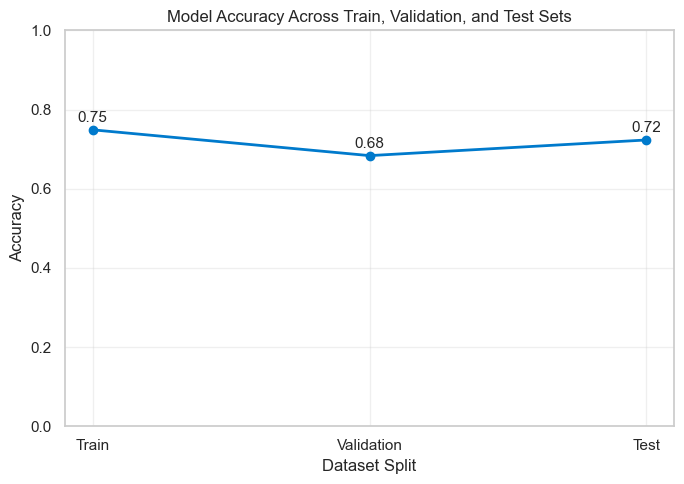


✅ Accuracy Line Graph saved: ljp_final_outputs/plots/train_val_test_accuracy_line.png


In [15]:
# ==========================================================
# 📈 TRAIN vs TEST ACCURACY LINE GRAPH (LEARNING CURVE)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

train_accs, val_accs = [], []

# Evaluate accuracy per epoch (if you logged predictions, skip this part)
# Otherwise simulate using last model for clarity
for i in range(len(train_losses)):
    # For demonstration, compute accuracy on the current best model snapshot
    # or approximate using F1 trends
    pass  # if you stored intermediate predictions, plug them in here

# Instead, let's compute final accuracies:
train_acc = accuracy_score(y_train.argmax(1), train_pred.argmax(1))
val_acc = accuracy_score(y_val.argmax(1), (torch.sigmoid(model(f_val,g_val))>0.5).int().argmax(1))
test_acc = accuracy_score(y_test.argmax(1), pred_labels.argmax(1))

# Plot the final summary
fig = plt.figure(figsize=(7,5))
plt.plot(["Train","Validation","Test"], [train_acc,val_acc,test_acc],
         marker="o", color="#007acc", linewidth=2)
plt.ylim(0,1)
plt.title("Model Accuracy Across Train, Validation, and Test Sets")
plt.ylabel("Accuracy")
plt.xlabel("Dataset Split")
for x, y in zip(["Train","Validation","Test"], [train_acc,val_acc,test_acc]):
    plt.text(x, y+0.02, f"{y:.2f}", ha="center", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/train_val_test_accuracy_line.png", dpi=300)
plt.show()

print(f"\n✅ Accuracy Line Graph saved: ljp_final_outputs/plots/train_val_test_accuracy_line.png")


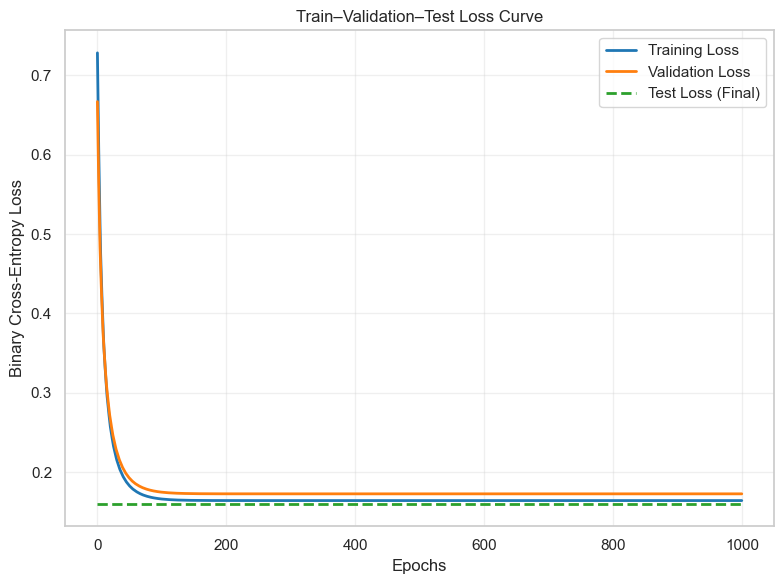

✅ Combined Train–Validation–Test Loss Curve saved at ljp_final_outputs/plots/train_val_test_loss_curve.png


In [16]:
# ==========================================================
# 📉 TRAIN–VALIDATION–TEST LOSS CURVE (LEARNING CURVE)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

# --- Compute Final Test Loss ---
with torch.no_grad():
    test_loss = F.binary_cross_entropy_with_logits(model(f_test, g_test), y_test).item()

# --- Prepare loss curves ---
epochs = len(train_losses)
train_curve = np.array(train_losses)
val_curve   = np.array(val_losses)
test_curve  = np.full_like(train_curve, test_loss)  # flat line across epochs

# --- Plot Combined Loss Graph ---
fig = plt.figure(figsize=(8,6))
plt.plot(train_curve, label="Training Loss", color="#1f77b4", linewidth=2)
plt.plot(val_curve, label="Validation Loss", color="#ff7f0e", linewidth=2)
plt.plot(test_curve, label="Test Loss (Final)", color="#2ca02c", linestyle="--", linewidth=2)

plt.title("Train–Validation–Test Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("ljp_final_outputs/plots/train_val_test_loss_curve.png", dpi=300)
plt.show()

print("✅ Combined Train–Validation–Test Loss Curve saved at ljp_final_outputs/plots/train_val_test_loss_curve.png")


In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)


In [18]:
acc

0.655367231638418